In [100]:
# --- Letter class ---
class Letter:
    def __init__(self, letter: str):
        self.letter = letter.lower()
        self.in_word = False
        self.in_correct_place = False
        self.index = None

    def mark_as_in_word(self):
        self.in_word = True

    def mark_as_in_correct_place(self):
        self.in_word = True
        self.in_correct_place = True

    def is_in_word(self) -> bool:
        return self.in_word

    def is_in_correct_place(self) -> bool:
        return self.in_correct_place

    def __repr__(self):
        return (
            f"Letter('{self.letter}', in_word={self.in_word}, "
            f"in_correct_place={self.in_correct_place})"
        )


In [101]:
# --- DisplaySpecification class ---
class DisplaySpecification:
    block_width: int = 80
    block_height: int = 80
    correct_location_color: str = "#00274C"
    incorrect_location_color: str = "#FFCB05"
    incorrect_color: str = "#D3D3D3"
    space_between_letters: int = 5
    word_color: str = "#FFFFFF"


In [102]:
# --- Bot class ---
import random
from PIL import Image

class Bot:
    def __init__(self, words_file: str, display_spec: DisplaySpecification):
        self.display_spec = display_spec
        with open(words_file, "r") as f:
            self.words = [word.strip().lower() for word in f.readlines()]
        self.word_list = self.words
        self.guesses = []

    @staticmethod
    def _tuple_to_str(pixels: tuple) -> str:
        return "#{:02X}{:02X}{:02X}".format(*pixels[:3])

    def _process_image(self, guess: str, guess_image: Image.Image) -> list[Letter]:
        spec = self.display_spec
        tile_width = guess_image.width // len(guess)
        y = guess_image.height // 2
        feedback_letters = []

        for i, char in enumerate(guess):
            x = i * tile_width + tile_width // 2
            pixel = guess_image.getpixel((x, y))
            color_hex = self._tuple_to_str(pixel).upper()

            letter = Letter(char.upper())
            letter.index = i

            if color_hex == spec.correct_location_color.upper():
                letter.mark_as_in_correct_place()
            elif color_hex == spec.incorrect_location_color.upper():
                letter.mark_as_in_word()

            feedback_letters.append(letter)

        return feedback_letters

    def record_guess_results(self, guess: str, guess_image: Image.Image):
        feedback_letters = self._process_image(guess, guess_image)
        self.guesses.append((guess, feedback_letters))

    def make_guess(self) -> str:
        guessed_words = {g[0].lower() for g in self.guesses}
        candidates = [word for word in self.word_list if word not in guessed_words]
        return random.choice(candidates).upper() if candidates else random.choice(self.word_list).upper()


In [103]:
# --- GameEngine class ---
from PIL import Image, ImageFont, ImageDraw
import random

class GameEngine:
    def __init__(self, display_spec: DisplaySpecification = None) -> None:
        if display_spec is None:
            display_spec = DisplaySpecification()
        self.display_spec = display_spec
        self.err_input = False
        self.err_guess = False
        self.prev_guesses = []

    def play(self, bot: Bot, word_list_file: str = "words.txt", target_word: str = None) -> Image:
        def format_results(results) -> str:
            response = ""
            for letter in results:
                if letter.is_in_correct_place():
                    response += letter.letter
                elif letter.is_in_word():
                    response += "*"
                else:
                    response += "?"
            return response

        word_list: list[str] = list(map(lambda x: x.strip().upper(), open(word_list_file, "r").readlines()))
        known_letters: list[str] = [None, None, None, None, None]
        unused_letters = set()

        if target_word is None:
            target_word = random.choice(word_list).upper()
        else:
            target_word = target_word.upper()
            if target_word not in word_list:
                print(f"Target word {target_word} must be from the word list")
                self.err_input = True
                return

        print(f"Target word for this round is {target_word}")

        MAX_GUESSES = 6
        for i in range(1, MAX_GUESSES):
            guess: str = bot.make_guess()
            print(f"Evaluating bot guess: {guess}")

            if guess not in word_list:
                print(f"Invalid guess: {guess}")
                self.err_guess = True
            elif guess in self.prev_guesses:
                print(f"Repeated guess: {guess}")
                self.err_guess = True

            if self.err_guess:
                return

            self.prev_guesses.append(guess)

            for j, letter in enumerate(guess):
                if letter in unused_letters:
                    print(f"Used known-unused letter: {letter}")
                    self.err_guess = True
                if known_letters[j] is not None and letter != known_letters[j]:
                    print(f"Wrong letter at known correct position {j}")
                    self.err_guess = True

            if self.err_guess:
                return

            correct, results = self._set_feedback(guess, target_word)
            print(f"Correct guess? {correct}")

            img = self._format_results(results)
            from IPython.display import display
            display(img)

            bot.record_guess_results(guess, img)

            if correct:
                print(f"Found the word in {i} guesses!")
                return

        print("Game over. Bot failed to guess the word.")

    def _set_feedback(self, guess: str, target_word: str) -> tuple[bool, list[Letter]]:
        correct = True
        letters = []
        for j in range(len(guess)):
            letter = Letter(guess[j])
            if guess[j] == target_word[j]:
                letter.in_correct_place = True
            else:
                correct = False
            if guess[j] in target_word:
                letter.in_word = True
            letters.append(letter)
        return correct, letters

    def _render_letter(self, letter: Letter) -> Image:
        color: str = self.display_spec.incorrect_color
        if letter.is_in_correct_place():
            color = self.display_spec.correct_location_color
        elif letter.is_in_word():
            color = self.display_spec.incorrect_location_color

        block = Image.new("RGB", (self.display_spec.block_width, self.display_spec.block_height), color=color)
        draw = ImageDraw.Draw(block)
        X = self.display_spec.block_width // 2
        Y = self.display_spec.block_height // 2

        # Using safe default font
        try:
            font = ImageFont.truetype("Roboto-Bold.ttf", 60)
        except OSError:
            font = ImageFont.load_default()
        draw.text((X, Y), letter.letter, anchor="mm", font=font)

        return block

    def _format_results(self, letters: list[Letter]) -> Image:
        WORD_WIDTH = (len(letters) * self.display_spec.block_width) + \
                     (len(letters) - 1) * self.display_spec.space_between_letters
        WORD_HEIGHT = self.display_spec.block_height

        word = Image.new("RGB", (WORD_WIDTH, WORD_HEIGHT), color=self.display_spec.word_color)
        curr_loc = 0
        for letter in letters:
            rendered_letter = self._render_letter(letter)
            word.paste(rendered_letter, (curr_loc, 0))
            curr_loc += self.display_spec.block_width + self.display_spec.space_between_letters
        return word


Target word for this round is DADDY
Evaluating bot guess: STATE
Correct guess? False


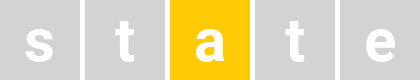

Evaluating bot guess: DOGGY
Correct guess? False


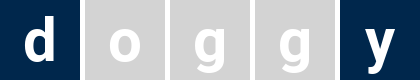

Evaluating bot guess: FIELD
Correct guess? False


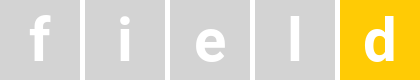

Evaluating bot guess: DADDY
Correct guess? True


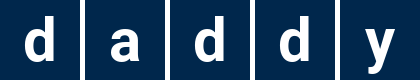

Found the word in 4 guesses!


In [104]:
# --- Run the game ---
if __name__ == "__main__":
    favorite_words = ["doggy", "drive", "daddy", "field", "state"]
    words_file = "temp_file.txt"
    with open(words_file, "w") as file:
        file.writelines("\n".join(favorite_words))

    ge = GameEngine()
    bot = Bot(words_file, ge.display_spec)
    ge.play(bot, word_list_file=words_file)
